In [1]:
import math
import itertools

# python3 -m pip install opencv-python
import cv2 # opencv
import numpy as np

from scipy.signal import convolve2d
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def imshow_with_colorbar(index, img):
    plt.figure(index)
    ax = plt.subplot(111)
    im = ax.imshow(img)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

# 3.1 Blob detection

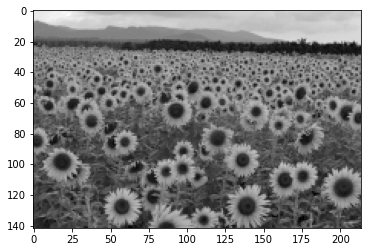

In [3]:
img = cv2.imread('../images/sunflowers_small.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')

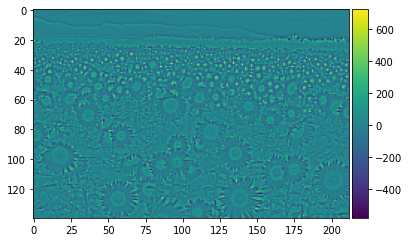

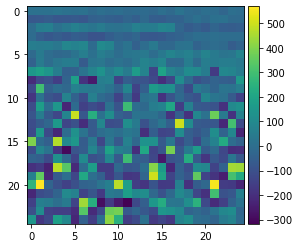

In [4]:
kernel = [
    [ 1,  1,  1],
    [ 1, -8,  1],
    [ 1,  1,  1],
]
img_c = convolve2d(img, kernel, mode='valid')
imshow_with_colorbar(1, img_c)
imshow_with_colorbar(2, img_c[15:40,25:50])

# 3.2 Blob detection - Laplacian of Gaussian

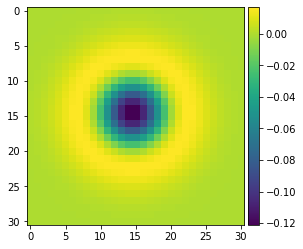

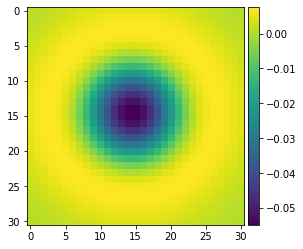

In [5]:
def generate_LoG_kernel(sz, sigma):
    def LoG(x, y, sigma):
        return ((x**2+y**2-2*sigma**2)/sigma**4)*math.exp(-1*(x**2+y**2)/(2*sigma**2))

    dsz = sz/2 - 1

    res = np.zeros((sz, sz), dtype=np.float)
    for y in range(sz):
        for x in range(sz):
            res[y,x] = LoG(x - dsz, y - dsz, sigma)
    return res

log_kernel = generate_LoG_kernel(31, 4)
imshow_with_colorbar(1, log_kernel)

log_kernel_2 = generate_LoG_kernel(31, 6)
imshow_with_colorbar(2, log_kernel_2)

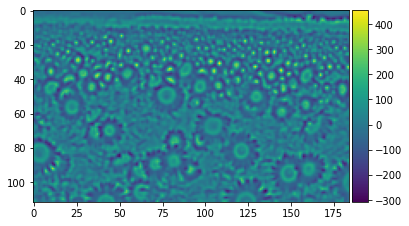

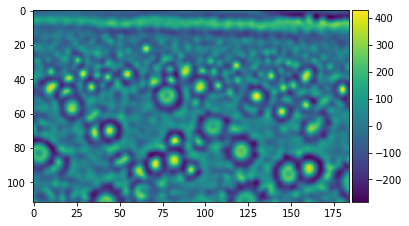

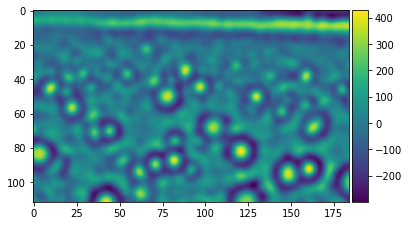

In [6]:
img = cv2.imread('../images/sunflowers_small.jpg', cv2.IMREAD_GRAYSCALE)

log_kernel_1 = generate_LoG_kernel(31, 1)
img_c_1 = convolve2d(img, log_kernel_1, mode='valid')
imshow_with_colorbar(1, img_c_1)

log_kernel_2 = generate_LoG_kernel(31, 2)
img_c_2 = convolve2d(img, log_kernel_2, mode='valid')
imshow_with_colorbar(2, img_c_2)

log_kernel_3 = generate_LoG_kernel(31, 3)
img_c_3 = convolve2d(img, log_kernel_3, mode='valid')
imshow_with_colorbar(3, img_c_3)

# 3.3 FAST features

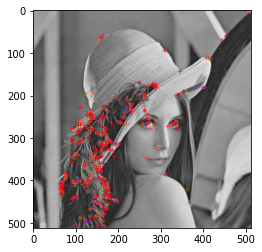

In [7]:
img = cv2.imread('../images/lenna.png', cv2.IMREAD_GRAYSCALE)
ff_detector = cv2.FastFeatureDetector_create(threshold=40)

kpts = ff_detector.detect(img)

img_out = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
cv2.drawKeypoints(img, kpts, img_out)
for kpt in kpts:
    y = int(kpt.pt[1])
    x = int(kpt.pt[0])
    cv2.line(img_out, (x-5,y), (x+5,y), (255,0,0))
    cv2.line(img_out, (x,y-5), (x,y+5), (255,0,0))

plt.imshow(img_out)
plt.show()

## FAST  Detector Implementation

In [8]:
class FASTDetector:
    def __init__(self, intensity_threshold=50, length_threshold=3, debug=False):
        self.intensity_threshold = intensity_threshold
        self.length_threshold = length_threshold
        self.debug = debug
        
    def _get_16pixel_circle_coords_around(self, y, x):
        ys = np.array([y-3, y-3, y-2, y-1, y+0, y+1, y+2, y+3, y+3, y+3, y+2, y+1, y+0, y-1, y-2, y-3]) 
        xs = np.array([x+0, x+1, x+2, x+3, x+3, x+3, x+2, x+1, x+0, x-1, x-2, x-3, x-3, x-3, x-2, x-1])

        return ys, xs
    
    def detect(self, image):
        h, w = image.shape
        image = image.astype(np.int64)

        for y in range(3, h-3):
            for x in range(3, w-3):
                center_intensity = image[y,x]
                circle_intensities = image[self._get_16pixel_circle_coords_around(y,x)]

                mask = ((circle_intensities - center_intensity) > self.intensity_threshold)
                sequences = [list(map(int, g)) for k, g in itertools.groupby(mask)]

                if len(sequences) == 2:
                    feature_found = min(len(s) for s in sequences) >= self.length_threshold
                elif len(sequences) == 3:
                    feature_found = self.length_threshold <= len(sequences[1]) and len(sequences[1]) <= 16 - self.length_threshold
                else:
                    feature_found = False
                    
                if feature_found:
                    if self.debug:
                        print(sequences)
                    
                    yield (y,x)

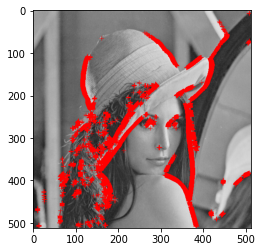

In [9]:
# Custom FAST feature detector usage example 

img = cv2.imread('../images/lenna.png', cv2.IMREAD_GRAYSCALE)

INTESITY_THRESHOLD = 80
NUM_CONTIGUOUS_PIXELS = 3 
DEBUG_FLAG = False  # Set to True to print the  

ff_detector = FASTDetector(
    intensity_threshold=INTESITY_THRESHOLD,
    length_threshold=NUM_CONTIGUOUS_PIXELS,
    debug=DEBUG_FLAG
)

kpts = ff_detector.detect(img)

img_out = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

for kpt in kpts:
    y = int(kpt[0])
    x = int(kpt[1])
    cv2.line(img_out, (x-5,y), (x+5,y), (255,0,0))
    cv2.line(img_out, (x,y-5), (x,y+5), (255,0,0))

plt.imshow(img_out)
plt.show()

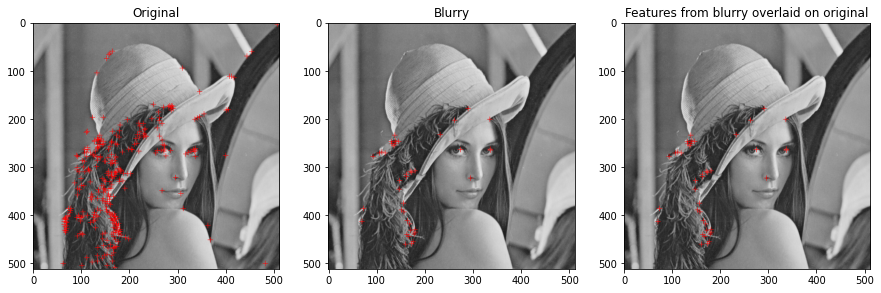

In [10]:
# Original vs Blury image feature detection comparison (using opencv-python, because it works faster)

GAUSSIAN_KERNEL_SIZE = (5, 5)

img = cv2.imread('../images/lenna.png', cv2.IMREAD_GRAYSCALE)

ff_detector = cv2.FastFeatureDetector_create(threshold=40)


kpts = ff_detector.detect(img)
img_out = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

for kpt in kpts:
    y = int(kpt.pt[1])
    x = int(kpt.pt[0])
    cv2.line(img_out, (x-5,y), (x+5,y), (255,0,0))
    cv2.line(img_out, (x,y-5), (x,y+5), (255,0,0))


blurry = cv2.GaussianBlur(img, GAUSSIAN_KERNEL_SIZE, 0)

kpts = ff_detector.detect(blurry)
blurry_out = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

for kpt in kpts:
    y = int(kpt.pt[1])
    x = int(kpt.pt[0])
    cv2.line(blurry_out, (x-5,y), (x+5,y), (255,0,0))
    cv2.line(blurry_out, (x,y-5), (x,y+5), (255,0,0))
    
combined_out = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

for kpt in kpts:
    y = int(kpt.pt[1])
    x = int(kpt.pt[0])
    cv2.line(combined_out, (x-5,y), (x+5,y), (255,0,0))
    cv2.line(combined_out, (x,y-5), (x,y+5), (255,0,0))

_, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

axes[0].set_title('Original')
axes[0].imshow(img_out)

axes[1].set_title('Blurry')
axes[1].imshow(blurry_out)

axes[2].set_title('Features from blurry overlaid on original')
axes[2].imshow(combined_out)

plt.show()

# Explanation: blurry image has smooth color transition that's why the smaller number of features were detected.
# The threshold condition will be satisfied for smaller number of center pixels. 

Scaling factor: 2


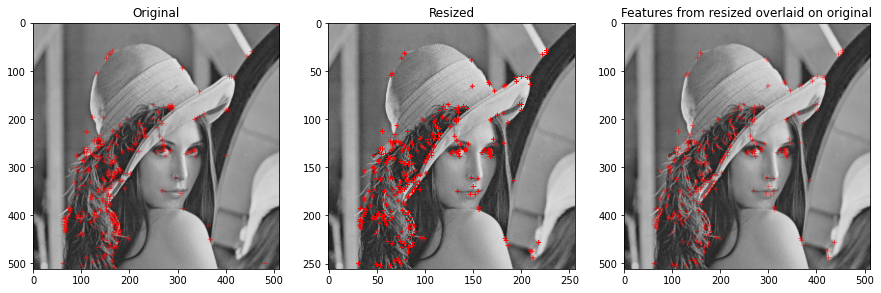

Scaling factor: 4


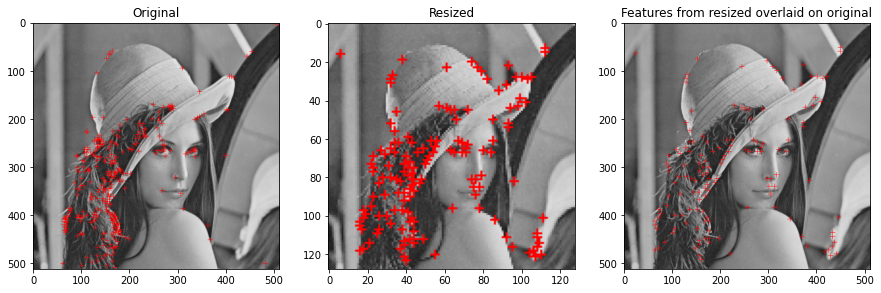

Scaling factor: 6


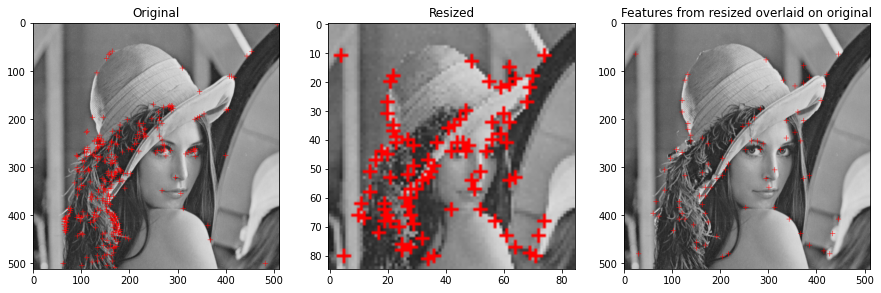

Scaling factor: 8


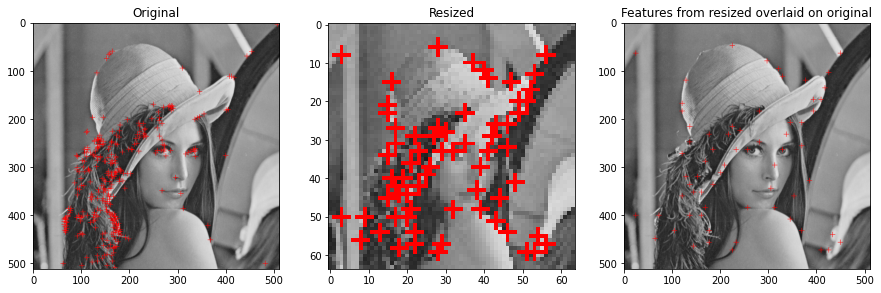

In [11]:
# Using cv2.resize

for SCALING_FACTOR in [2, 4, 6, 8]:
    print('Scaling factor:', SCALING_FACTOR)
    
    resized_img_shape = (img.shape[0] // SCALING_FACTOR, img.shape[1] // SCALING_FACTOR)


    img = cv2.imread('../images/lenna.png', cv2.IMREAD_GRAYSCALE)

    ff_detector = cv2.FastFeatureDetector_create(threshold=40)

    kpts = ff_detector.detect(img)
    img_out = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    for kpt in kpts:
        y = int(kpt.pt[1])
        x = int(kpt.pt[0])
        cv2.line(img_out, (x-5,y), (x+5,y), (255,0,0))
        cv2.line(img_out, (x,y-5), (x,y+5), (255,0,0))

    resized_img = cv2.resize(img, resized_img_shape, interpolation=cv2.INTER_NEAREST)

    kpts = ff_detector.detect(resized_img)
    resized_out = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)

    for kpt in kpts:
        y = int(kpt.pt[1])
        x = int(kpt.pt[0])
        cv2.line(resized_out, (x-2,y), (x+2,y), (255,0,0))
        cv2.line(resized_out, (x,y-2), (x,y+2), (255,0,0))

    combined_out = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    for kpt in kpts:
        y = int(kpt.pt[1] * SCALING_FACTOR)
        x = int(kpt.pt[0] * SCALING_FACTOR)
        cv2.line(combined_out, (x-5,y), (x+5,y), (255,0,0))
        cv2.line(combined_out, (x,y-5), (x,y+5), (255,0,0))

    _, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    axes[0].set_title('Original')
    axes[0].imshow(img_out)

    axes[1].set_title('Resized')
    axes[1].imshow(resized_out)

    axes[2].set_title('Features from resized overlaid on original')
    axes[2].imshow(combined_out)

    plt.show()

# Explanation: obviously the smaller number of the feature will be detected on resized image, 
# because the image size is smaller. We lose some smaller features but instead we are able to 
# grasp more highlevel features.

Scaling factor: 2


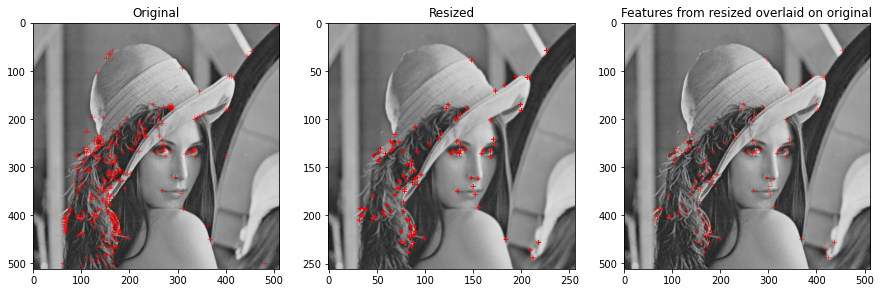

Scaling factor: 4


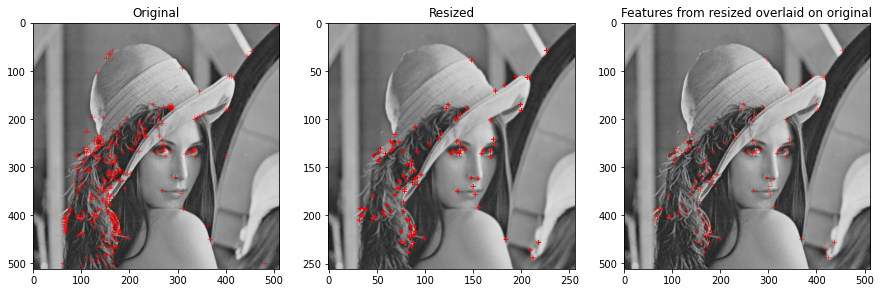

Scaling factor: 6


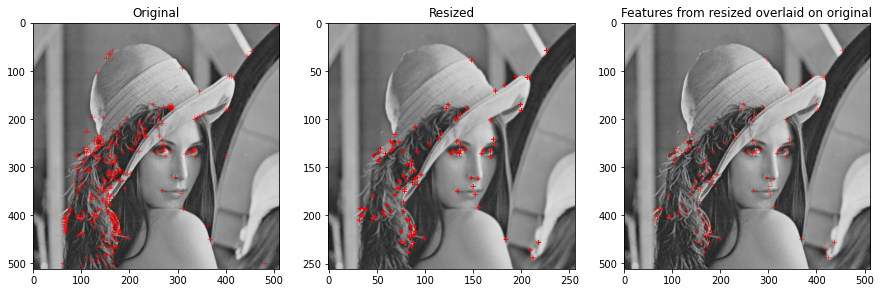

Scaling factor: 8


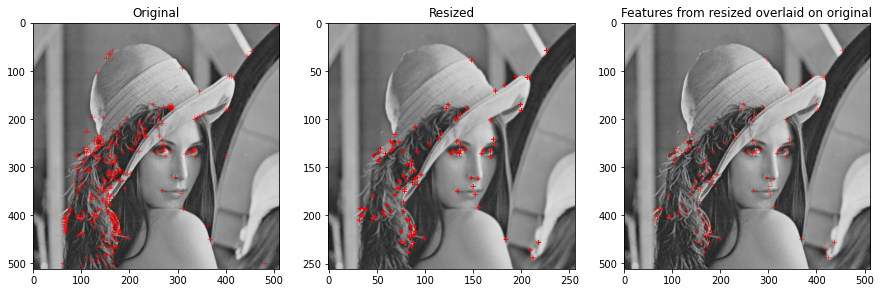

In [12]:
# Using cv2.pyrDown


for SCALING_FACTOR in [2, 4, 6, 8]:
    print('Scaling factor:', SCALING_FACTOR)

    img = cv2.imread('../images/lenna.png', cv2.IMREAD_GRAYSCALE)

    ff_detector = cv2.FastFeatureDetector_create(threshold=40)

    kpts = ff_detector.detect(img)
    img_out = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    for kpt in kpts:
        y = int(kpt.pt[1])
        x = int(kpt.pt[0])
        cv2.line(img_out, (x-5,y), (x+5,y), (255,0,0))
        cv2.line(img_out, (x,y-5), (x,y+5), (255,0,0))

    resized_img = cv2.pyrDown(img)
    SCALING_FACTOR = img.shape[0] // resized_img.shape[0]


    kpts = ff_detector.detect(resized_img)
    resized_out = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)

    for kpt in kpts:
        y = int(kpt.pt[1])
        x = int(kpt.pt[0])
        cv2.line(resized_out, (x-2,y), (x+2,y), (255,0,0))
        cv2.line(resized_out, (x,y-2), (x,y+2), (255,0,0))

    combined_out = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    for kpt in kpts:
        y = int(kpt.pt[1] * SCALING_FACTOR)
        x = int(kpt.pt[0] * SCALING_FACTOR)
        cv2.line(combined_out, (x-5,y), (x+5,y), (255,0,0))
        cv2.line(combined_out, (x,y-5), (x,y+5), (255,0,0))

    _, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    axes[0].set_title('Original')
    axes[0].imshow(img_out)

    axes[1].set_title('Resized')
    axes[1].imshow(resized_out)

    axes[2].set_title('Features from resized overlaid on original')
    axes[2].imshow(combined_out)

    plt.show()

# Explanation: the color transition in the resized image is smoothed that's why we loose some features .

# BRIEF Descriptor

In [13]:
class BRIEFDescriptor:
    def __init__(self, patch_size, num_samples):
        self.patch_size = patch_size # size of the square window in pixels
        self.num_samples = num_samples # number of lines to sample
        
    def decribe(self, image, feature_location):
        y, x = feature_location
        
        relative_yx_pairs = []
        feature_vector = []
        
        for _ in range(self.num_samples):
            p1 = self._sample_point(center=(y, x))
            p2 = self._sample_point(center=(y, x))
            
            feature_vector.append(self._test(image, p1, p2))
            relative_yx_pairs.append(((y - p1[0], x-p1[1]), (y - p2[0], x-p2[1])))
            
        return relative_yx_pairs, feature_vector
            
        
    def _sample_point(self, center):
        y, x = center
        
        p_y = np.random.randint(y-self.patch_size, y+self.patch_size)
        p_x = np.random.randint(x-self.patch_size, x+self.patch_size)
        
        return (p_y, p_x)
        
    
    def _test(self, image, p1, p2):
        return int(image[p1[0], p1[1]] < image[p2[0], p2[1]])
        

In [14]:
# Smoke test

img = cv2.imread('../images/lenna.png', cv2.IMREAD_GRAYSCALE)

descriptor = BRIEFDescriptor(20, 25)
relative_yx_pairs, feature_vector = descriptor.decribe(img, (50, 50))

print(feature_vector)

[1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0]


# 3.4 Harris Corner Detector

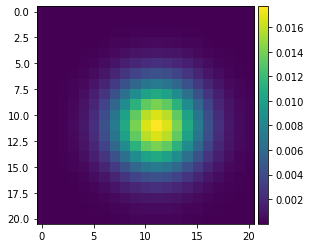

In [15]:
sigma = 3
test = np.zeros((21, 21), dtype=np.float)
test[11,11] = 1
test_out = np.zeros((21, 21), dtype=np.float)

test_out = gaussian_filter(test, sigma)

imshow_with_colorbar(1, test_out)

In [16]:
def harris(im,sigma=3): # calculate Harris corner detector response function
    img = im.astype(np.float)

    # derivatives
    imgx = gaussian_filter(img, (sigma,sigma), (0,1))
    imgy = gaussian_filter(img, (sigma,sigma), (1,0))

    # components of the Harris matrix
    Wxx = gaussian_filter(imgx*imgx, sigma)
    Wxy = gaussian_filter(imgx*imgy, sigma)
    Wyy = gaussian_filter(imgy*imgy, sigma)

    # determinant and trace
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy

    return Wdet - 0.01 * Wtr * Wtr
    # return Wdet / Wtr

def harrisPoints(harrisim, min_dist=10, threshold=0.1):
    # find top corner candidates
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1
    
    # get coordinates of candidates
    coords = np.array(harrisim_t.nonzero()).T
    
    #get values of candidates
    candidate_values = [harrisim[c[0],c[1]] for c in coords]
    
    # sort candidates
    index = np.argsort(candidate_values)[::-1]
    
    # store allowed point locations in array
    allowed_locations = np.zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1
    
    # select the best points using min_distance
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i,0],coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i,0]-min_dist):(coords[i,0]+min_dist),
                        (coords[i,1]-min_dist):(coords[i,1]+min_dist)] = 0
    
    return filtered_coords

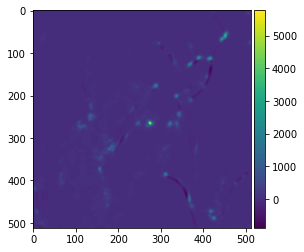

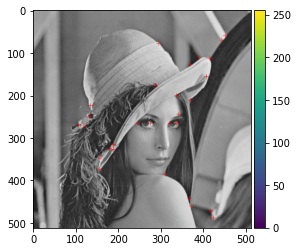

In [17]:
img = cv2.imread('../images/lenna.png', cv2.IMREAD_GRAYSCALE)

img_harris = harris(img)
pts = harrisPoints(img_harris)

img_out = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

for pt in pts:
    y, x = pt[0], pt[1]
    cv2.line(img_out, (x-5,y), (x+5,y), (255,0,0))
    cv2.line(img_out, (x,y-5), (x,y+5), (255,0,0))

imshow_with_colorbar(1, img_harris)
imshow_with_colorbar(2, img_out)


# 3.4 Feature matching process

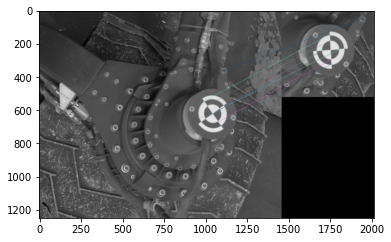

In [18]:
img1 = cv2.imread('../images/curiosity_cut.jpg',cv2.IMREAD_GRAYSCALE)    # queryImage
img2 = cv2.imread('../images/curiosity_marker.jpg',cv2.IMREAD_GRAYSCALE) # trainImage

orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(des1,des2)

matches = sorted(matches, key = lambda x:x.distance)
img_match = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img_match)